### Домашнее задание

#### 1. Загрузка и первичный анализ датасета 📥
- Скачайте датасет [из этого источника](https://archive.ics.uci.edu/dataset/360/air+quality).
- Выведите 5 случайных записей из датасета для ознакомления.
- Изучите описание датасета, чтобы понять структуру данных.

#### 2. Предобработка данных 🔧
- Приведите все числовые признаки к типу `integer` или `float`, а категориальные признаки — к типу `object`.
- Удалите строки и столбцы, где процент пропусков больше 90. Для остальных признаков, где процент пропусков не больше 90 - используйте simple inputer по примеру из ноутбука Lesson 11.
  
#### 3. Формирование целевой переменной 🎯
- Используйте признак `'C6H6(GT)'` в качестве целевой переменной.
- Преобразуйте его в бинарную переменную: если значение больше медианы, присвойте — 1, иначе — 0.
- Проведите масштабирование и используйте target mean encoder для категориальных признаков.
- Выведите корреляциюю признаков с таргетом в виде графика. Вид графика выберите на ваше усмотрение.

#### 4. Обучение моделей KNN и Logistic Regression 📊
- Обучите модели KNN и Logistic Regression.
- Выведите таблицу с AUC для каждой модели на обучающем и тестовом наборах.
- Сделайте выводы о наличии переобучения или недообучения моделей (письменно)

#### 5. Анализ важности признаков 🔍
- Проанализируйте важность признаков для обеих моделей.
- Сделайте выводы о возможной утечке информации из целевой переменной.

#### 6. Оценка модели с использованием кросс-валидации 🔄
- Для лучшей модели проведите кросс-валидацию с использованием K-fold и Stratified K-fold.
- Выведите среднее значение и стандартное отклонение для каждой схемы кросс-валидации.

#### 7. Реализация Leave-One-Out Cross Validation 🧑‍🏫
- Напишите функцию, которая принимает датасет и проводит Leave-One-Out кросс-валидацию для метрики roc-auc.
- Обязательно используйте `typing` для аннотации типов данных в функции.
- Проведите LOOCV для 100 рандомных значений из датасета. Установите random_state = 42 при выборе 100 значений через метод sample.

#### 8. Задание с самостоятельным изучением: Подбор параметров моделей с использованием GridSearch 🔍
- Проведите подбор гиперпараметров для моделей KNN и Logistic Regression с использованием библиотеки `GridSearch`.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, LeaveOneOut, LeavePOut, \
                                    GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix

from category_encoders import TargetEncoder
from itertools import combinations
from typing import Dict, Tuple

## 1. Загрузка и первичный анализ датасета 📥
- Скачайте датасет [из этого источника](https://archive.ics.uci.edu/dataset/360/air+quality).
- Выведите 5 случайных записей из датасета для ознакомления.
- Изучите описание датасета, чтобы понять структуру данных.

In [3]:
# Я взлял файл excel не потому что в нем уже уделаны пустые строки и столбцы,
# а потому что в csv файле есть округление до 4 знаков после запятой.
# Подумал больше знаков после запятой могут играть какую-то роль,
# а если нет быстренко округлю до 4 знаков

# Для Jupyter Notebook
df = pd.read_excel("../datasets/AirQualityUCI.xlsx")

# Для Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_excel('/content/drive/My Drive/homeworks/AirQualityUCI.xlsx')

warnings.filterwarnings("ignore")

df.sample(5, random_state=42)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
2973,2004-07-12,15:00:00,1.3,932.75,-200,6.412912,830.75,105.0,888.25,72.0,1514.00,709.50,25.950,34.850,1.150921
3396,2004-07-30,06:00:00,-200.0,894.00,-200,4.941889,760.50,36.0,861.50,48.0,1503.75,768.00,23.025,49.875,1.384914
4372,2004-09-08,22:00:00,2.6,1225.75,-200,14.649682,1137.50,307.0,861.75,146.0,1481.00,1418.75,25.100,32.250,1.013075
6025,2004-11-16,19:00:00,3.1,1100.75,-200,14.539883,1134.00,427.0,683.25,168.0,1283.00,1280.75,13.550,33.975,0.525066
7960,2005-02-05,10:00:00,1.3,965.75,-200,4.936948,760.25,301.7,876.75,200.1,889.50,940.25,7.525,39.225,0.409122


In [4]:
df.shape

(9357, 15)

### Описание данных:

1. **Date (Дата)** – Дата измерения.
2. **Time (Время)** – Время измерения.
3. **CO(GT) (Монооксид углерода, CO)** – Концентрация угарного газа в воздухе (в мг/м³).
4. **PT08.S1(CO)** – Выходные данные датчика, связанного с CO.
5. **NMHC(GT) (Неметановые летучие органические соединения, NMHC)** – Концентрация NMHC в воздухе (в мкг/м³).
6. **C6H6(GT) (Бензол, C₆H₆)** – Концентрация бензола в воздухе (мг/м³).
7. **PT08.S2(NMHC)** – Выходные данные датчика, связанного с NMHC.
8. **NOx(GT) (Оксиды азота, NOx)** – Концентрация оксидов азота (NO и NO₂) в мкг/м³.
9. **PT08.S3(NOx)** – Выходные данные датчика, связанного с NOx.
10. **NO2(GT) (Диоксид азота, NO₂)** – Концентрация NO₂ в воздухе (мкг/м³).
11. **PT08.S4(NO2)** – Выходные данные датчика, связанного с NO₂.
12. **PT08.S5(O3) (Озон, O₃)** – Выходные данные датчика, связанного с O₃.
13. **T (Температура, °C)** – Температура воздуха в градусах Цельсия.
14. **RH (Относительная влажность, %)** – Влажность воздуха в процентах.
15. **AH (Абсолютная влажность)** – Абсолютная влажность воздуха.

Меня очень беспокоет что в столбце **NMHC(GT)** очень много значений **-200**.
Думаю что это пропуски и с ними нужно разобраться...

**P.S.** Спасибо **GPT** за описание, иначе я только бы и понял **Date**, **Time** и вожможно **T** и ни за чтобы не понял что речь идет о качестве воздуха, а не о реакциях внутри черной дыры.
Использовал **GPT** только для описания данных. Остальное сам домучился (Времены было достаточно)

---

## 2. Предобработка данных 🔧
- Приведите все числовые признаки к типу `integer` или `float`, а категориальные признаки — к типу `object`.
- Удалите строки и столбцы, где процент пропусков больше 90. Для остальных признаков, где процент пропусков не больше 90 - используйте simple inputer по примеру из ноутбука Lesson 11.

In [5]:
df.dtypes

Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                  int64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
dtype: object

In [6]:
df["Date"] = df["Date"].astype(str)
df["Time"] = df["Time"].astype(str)

df["DateTime"] = pd.to_datetime(df["Date"] + " " + df["Time"])
print(f'Количество строк в данных: {df.shape[0]}')
print(f'Количество уникальных значений в Datetime: {df["DateTime"].nunique()}')

df = df.set_index(df["DateTime"]).sort_index()
df = df.drop(columns=["DateTime"])

df.index = df.index.strftime('%Y-%m-%d %H:%M')
df = df.sort_index()
df

Количество строк в данных: 9357
Количество уникальных значений в Datetime: 9357


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
DateTime,,,,,,,,,,,,,,,
2004-03-10 18:00,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
2004-03-10 19:00,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2004-03-10 20:00,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
2004-03-10 21:00,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
2004-03-10 22:00,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
2005-04-04 11:00,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
2005-04-04 12:00,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649


In [7]:
df.isna().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [8]:
df = df.replace(-200, np.nan)

# Поиск и удление пропусков в строках
missing_values = df.T.isna().sum().sort_values(ascending=False)

missing_columns = missing_values[missing_values > 0].sort_values(ascending=False)

missing_percent = (missing_columns/df.shape[1]).round(3)

df = df.drop(index=(missing_percent[missing_percent > 0.9].index))


# Поиск и удление пропусков в столбцах
missing_values = df.isna().sum().sort_values(ascending=False)

missing_columns = missing_values[missing_values > 0].sort_values(ascending=False)

missing_percent = (missing_columns/df.shape[0]).round(3)
print(missing_percent)

df = df.drop(columns=(missing_percent[missing_percent > 0.9].index))

NMHC(GT)         0.902
CO(GT)           0.180
NO2(GT)          0.175
NOx(GT)          0.175
PT08.S1(CO)      0.039
C6H6(GT)         0.039
PT08.S2(NMHC)    0.039
PT08.S3(NOx)     0.039
PT08.S4(NO2)     0.039
PT08.S5(O3)      0.039
T                0.039
RH               0.039
AH               0.039
dtype: float64


In [9]:
print("\nКоличество пропусков в столбцах:")
(df.isna().sum().sort_values(ascending=False)/df.shape[0]).round(3)


Количество пропусков в столбцах:


CO(GT)           0.180
NO2(GT)          0.175
NOx(GT)          0.175
PT08.S1(CO)      0.039
C6H6(GT)         0.039
PT08.S2(NMHC)    0.039
PT08.S3(NOx)     0.039
PT08.S4(NO2)     0.039
PT08.S5(O3)      0.039
T                0.039
RH               0.039
AH               0.039
Date             0.000
Time             0.000
dtype: float64

In [10]:
# Удаляю все строки где таргет не известен
df = df.dropna(subset=["C6H6(GT)"])

# Проверка пустых строк после удаления таргета
df.isna().sum()

Date                0
Time                0
CO(GT)           1647
PT08.S1(CO)         0
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)          1595
PT08.S3(NOx)        0
NO2(GT)          1598
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
dtype: int64

In [11]:
# Создаю переменные месяц и час
df["Month"] = df["Date"].apply(lambda date: date.split('-')[1])
df["Hour"] = df["Time"].apply(lambda time: time.split(":")[0])

# Удаляю переменную дата и время
df = df.drop(columns=["Date", "Time"])

In [12]:
# Разделяю на фичи и таргет
X = df.drop(columns="C6H6(GT)")
y = df["C6H6(GT)"]

# Разделяю категориальные и числовые признаки
categorical_features = X.select_dtypes("object").columns
numerical_features = X.select_dtypes("number").columns


In [13]:
# Создаю объекты класса SimpleImputer для разных типов данных
imputer_num = SimpleImputer(strategy="median")
imputer_cat = SimpleImputer(strategy="most_frequent")

# Заполюя пустые значения
X[numerical_features] = imputer_num.fit_transform(X[numerical_features])
X[categorical_features] = imputer_cat.fit_transform(X[categorical_features])

# Проверяю результат
X.isna().sum()

CO(GT)           0
PT08.S1(CO)      0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Month            0
Hour             0
dtype: int64

## 3. Формирование целевой переменной 🎯
- Используйте признак `'C6H6(GT)'` в качестве целевой переменной.
- Преобразуйте его в бинарную переменную: если значение больше медианы, присвойте — 1, иначе — 0.
- Проведите масштабирование и используйте target mean encoder для категориальных признаков.
- Выведите корреляциюю признаков с таргетом в виде графика. Вид графика выберите на ваше усмотрение.

In [14]:
# Делаю значение больше медианы 1, меньшне 0
y = (y >= y.median()).astype(int)

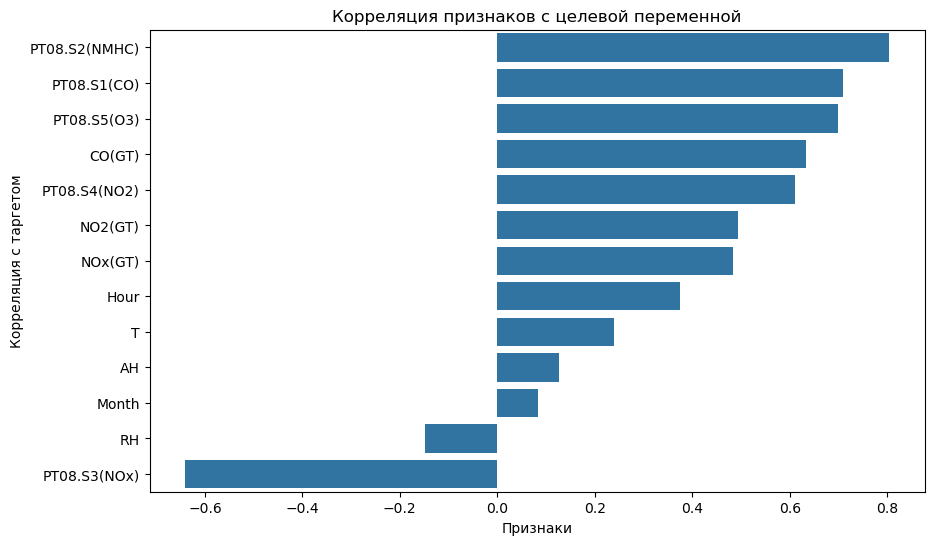

In [15]:
# Разделяю данные на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

df_train = X_train.copy()
df_train["target"] = y_train

corr_target = df_train.corr()["target"][:-1].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_target, y=corr_target.index)
plt.xlabel("Признаки")
plt.ylabel("Корреляция с таргетом")
plt.title("Корреляция признаков с целевой переменной")
plt.show()

In [16]:
def create_model_pipeline(model, numerical_features, categorical_features):
    """Создает пайплайн с предобработкой данных и выбранной моделью."""

    # Пайплайн для числовых признаков
    num_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    # Пайплайн для категориальных признаков
    cat_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", TargetEncoder())
    ])

    # Общий препроцессор
    preprocessor = ColumnTransformer([
        ("num", num_transformer, numerical_features),
        ("cat", cat_transformer, categorical_features)
    ])

    # Финальный пайплайн
    return Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

## 4. Обучение моделей KNN и Logistic Regression 📊
- Обучите модели KNN и Logistic Regression.
- Выведите таблицу с AUC для каждой модели на обучающем и тестовом наборах.
- Сделайте выводы о наличии переобучения или недообучения моделей (письменно)
## 5. Анализ важности признаков 🔍
- Проанализируйте важность признаков для обеих моделей.
- Сделайте выводы о возможной утечке информации из целевой переменной.

In [18]:
def fit_models(numerical_features, categorical_features):
    """
    Возращает словарь из 3-х обученных моделей (LR, KNN, DT)
    """


    # Словарь моделей с пайплайнами
    models = {
        "Logistic Regression": create_model_pipeline(LogisticRegression(),
                                                     numerical_features,
                                                     categorical_features),

        "KNN": create_model_pipeline(KNeighborsClassifier(n_neighbors=3),
                                     numerical_features,
                                     categorical_features),

        "Decision Tree": create_model_pipeline(DecisionTreeClassifier(max_depth=10),
                                               numerical_features,
                                               categorical_features)
    }

    # Обучаем модели
    for model_name, model in models.items():
        model.fit(X_train, y_train)

    return models

In [19]:
# Создаю функцию которая возращает датафрейм с AUC для каждой моделы
def train_test_auc_df(models, X_train, X_test):
    auc_scores = {
        "Train AUC": [],
        "Test AUC": []
    }

    for model_name, model in models.items():
        model.fit(X_train, y_train)

        y_train_pred_proba = model.predict_proba(X_train)[:, 1]
        y_test_pred_proba = model.predict_proba(X_test)[:, 1]

        train_auc = roc_auc_score(y_train, y_train_pred_proba)
        test_auc = roc_auc_score(y_test, y_test_pred_proba)

        auc_scores["Train AUC"].append(train_auc)
        auc_scores["Test AUC"].append(test_auc)

    return pd.DataFrame(auc_scores, index=models.keys()).round(4).T

In [20]:
models = fit_models(numerical_features, categorical_features)

auc_df = train_test_auc_df(models, X_train, X_test)

# Очень подозрительный результат
auc_df

,Logistic Regression,KNN,Decision Tree
Train AUC,0.9997,0.9985,1.0
Test AUC,0.9997,0.9864,1.0


In [21]:
def plot_feature_importance(model, numerical_features, categorical_features, model_name="Decision Tree"):
    """
    Строит график важности признаков для модели, если у неё есть атрибут feature_importances_.
    """

    if not hasattr(model.named_steps["classifier"], "feature_importances_"):
        print(f"Ошибка: модель {model_name} не поддерживает feature_importances_.")
        return

    feature_importance = model.named_steps["classifier"].feature_importances_

    features = numerical_features.tolist() + categorical_features.tolist()

    importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importance})
    importance_df = importance_df.sort_values(by="Importance", ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"])
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
    plt.title(f"Feature Importance ({model_name})")
    plt.show()


In [22]:
def plot_logistic_regression_importance(model, numerical_features, categorical_features):
    """Строит график важности признаков для Logistic Regression (по коэффициентам модели)."""

    feature_importance = model.named_steps["classifier"].coef_[0]

    features = numerical_features.tolist() + categorical_features.tolist()

    importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importance})
    importance_df = importance_df.sort_values(by="Importance", ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"])
    plt.xlabel("Коэффициент")
    plt.ylabel("Признак")
    plt.title("Feature Importance (Logistic Regression)")
    plt.show()

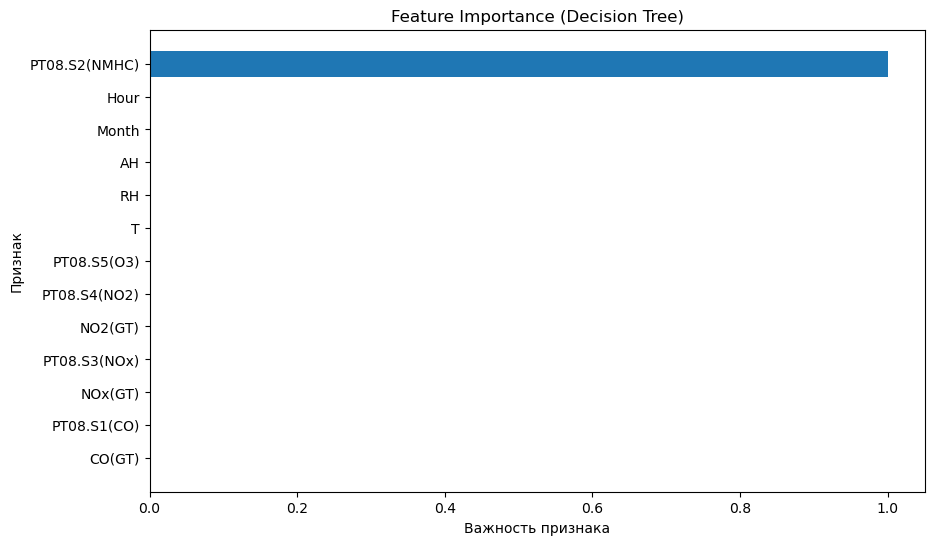

In [23]:
plot_feature_importance(models["Decision Tree"], numerical_features, categorical_features)

## Результат пункта 4 (1-я попытка):

О переобученности и недообученности модели говорить пока нельзя, но в моделе есть "утечка информации". Признак **PT08.S2(NMHC)**
знает о данных в таргете

---

,Logistic Regression,KNN,Decision Tree
Train AUC,0.9939,0.9979,0.9992
Test AUC,0.9936,0.9818,0.9457


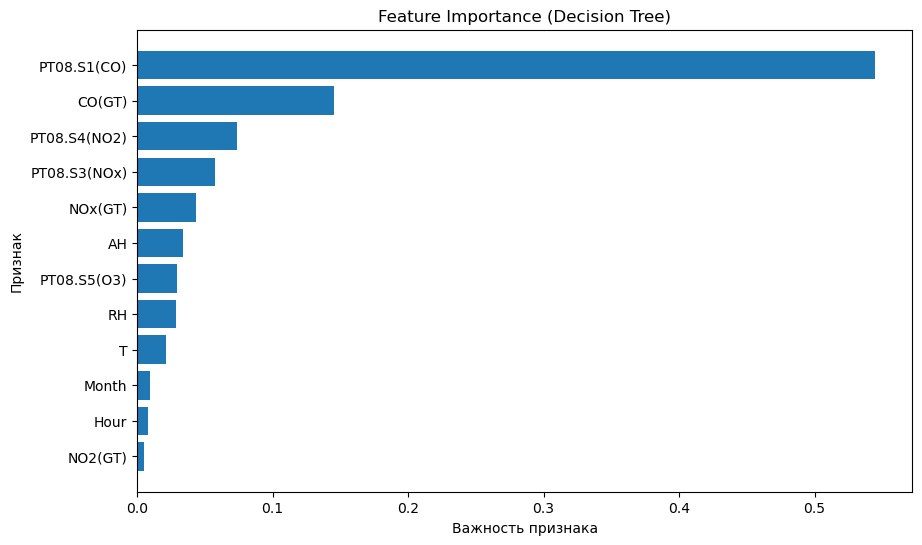

In [24]:
X_train = X_train.drop(columns="PT08.S2(NMHC)")
X_test = X_test.drop(columns="PT08.S2(NMHC)")

numerical_features = X_train.select_dtypes("number").columns
categorical_features = X_train.select_dtypes("object").columns

models = fit_models(numerical_features, categorical_features)

auc_df = train_test_auc_df(models, X_train, X_test)

# Все равно подозрительный результат
display(auc_df)

plot_feature_importance(models["Decision Tree"], numerical_features, categorical_features)

## Результат пункта 4 (2-я попытка):

О переобученности и недообученности модели говорить пока нельзя, но в моделе есть "утечка информации". Признак **PT08.S1(CO)**
знает о данных в таргете

---

,Logistic Regression,KNN,Decision Tree
Train AUC,0.9939,0.9979,0.9996
Test AUC,0.9936,0.9812,0.9300


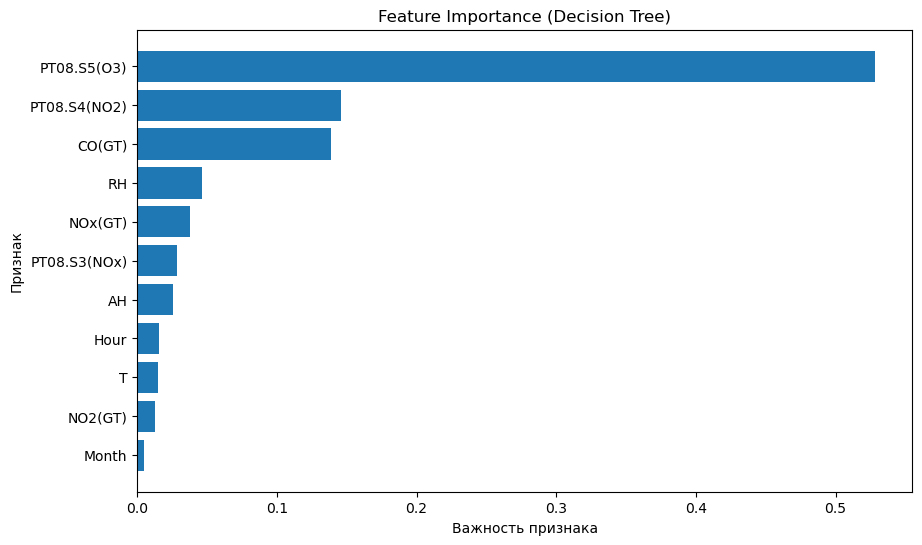

In [25]:
X_train = X_train.drop(columns="PT08.S1(CO)")
X_test = X_test.drop(columns="PT08.S1(CO)")

numerical_features = X_train.select_dtypes("number").columns
categorical_features = X_train.select_dtypes("object").columns

models = fit_models(numerical_features, categorical_features)

auc_df = train_test_auc_df(models, X_train, X_test)

# Это уже издевательство
display(auc_df)

plot_feature_importance(models["Decision Tree"], numerical_features, categorical_features)

## Результат пункта 4 (3-я попытка):

О переобученности и недообученности модели говорить пока нельзя, но в моделе есть "утечка информации". Признак **PT08.S5(O3)**
знает о данных в таргете

---

,Logistic Regression,KNN,Decision Tree
Train AUC,0.9931,0.9975,0.9995
Test AUC,0.9936,0.9804,0.9569


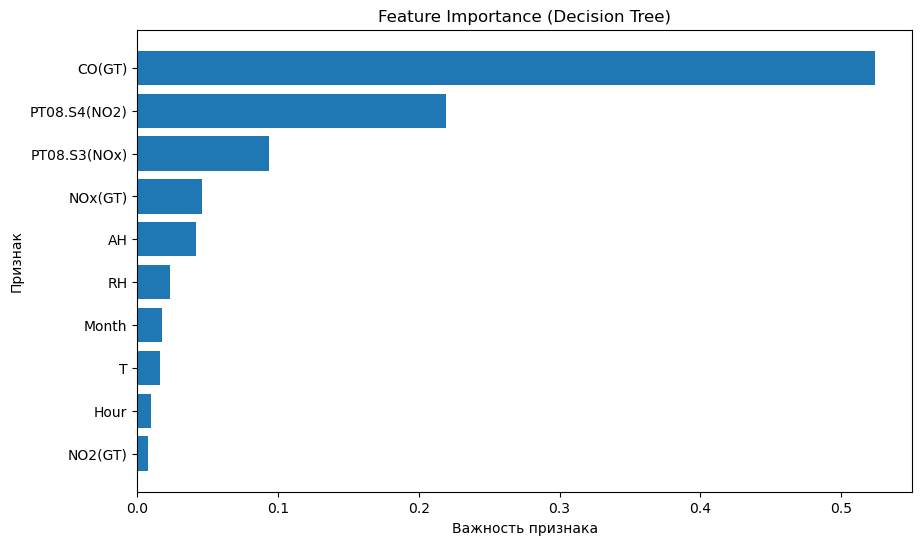

In [26]:
X_train = X_train.drop(columns="PT08.S5(O3)")
X_test = X_test.drop(columns="PT08.S5(O3)")

numerical_features = X_train.select_dtypes("number").columns
categorical_features = X_train.select_dtypes("object").columns

models = fit_models(numerical_features, categorical_features)

auc_df = train_test_auc_df(models, X_train, X_test)

# Я не знаю почему такой результат
display(auc_df)

plot_feature_importance(models["Decision Tree"], numerical_features, categorical_features)

## Результат пункта 4 (4-я попытка):

О переобученности и недообученности модели говорить пока нельзя, но в моделе есть "утечка информации". Признак **CO(GT)**
знает о данных в таргете

---

,Logistic Regression,KNN,Decision Tree
Train AUC,0.9922,0.9974,0.9996
Test AUC,0.9923,0.9788,0.9467


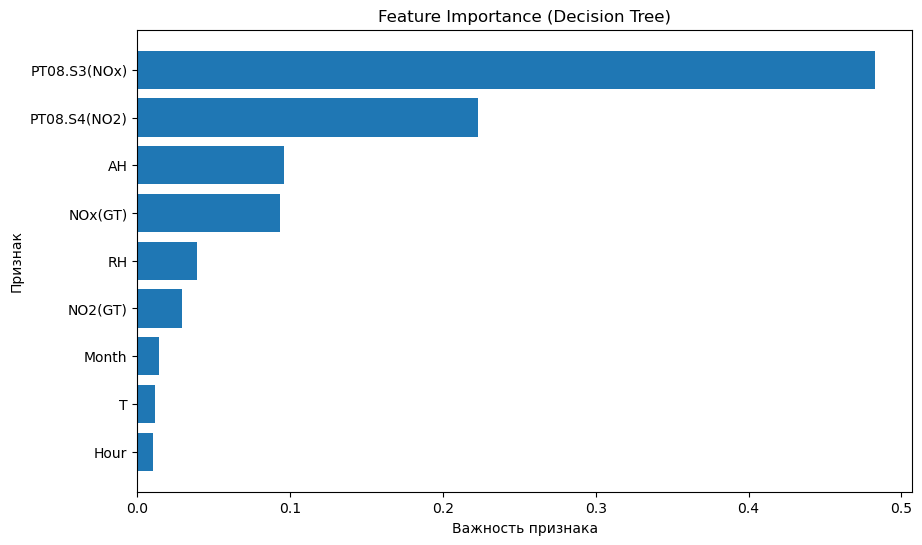

In [27]:
X_train = X_train.drop(columns="CO(GT)")
X_test = X_test.drop(columns="CO(GT)")

numerical_features = X_train.select_dtypes("number").columns
categorical_features = X_train.select_dtypes("object").columns

models = fit_models(numerical_features, categorical_features)

auc_df = train_test_auc_df(models, X_train, X_test)

# Я не знаю почему такой результат
display(auc_df)

plot_feature_importance(models["Decision Tree"], numerical_features, categorical_features)

## Результат пункта 4 (5-я попытка):

О переобученности и недообученности модели говорить пока нельзя, но в моделе есть "утечка информации". Признак **PT08.S3(NOx)**
знает о данных в таргете

---

,Logistic Regression,KNN,Decision Tree
Train AUC,0.9860,0.9959,0.9978
Test AUC,0.9843,0.9728,0.9435


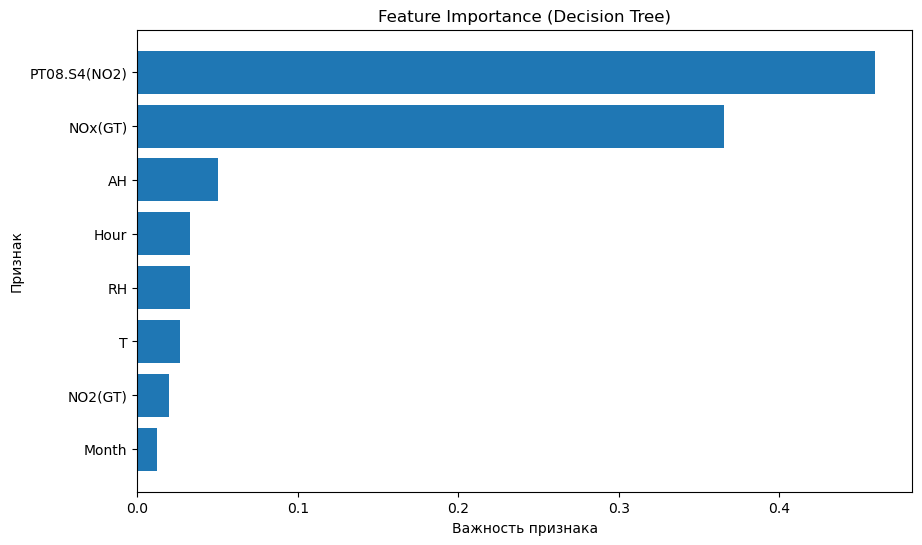

In [28]:
X_train = X_train.drop(columns="PT08.S3(NOx)")
X_test = X_test.drop(columns="PT08.S3(NOx)")

numerical_features = X_train.select_dtypes("number").columns
categorical_features = X_train.select_dtypes("object").columns

models = fit_models(numerical_features, categorical_features)

auc_df = train_test_auc_df(models, X_train, X_test)

# Я не знаю почему такой результат
display(auc_df)

plot_feature_importance(models["Decision Tree"], numerical_features, categorical_features)

## Результат пункта 4 (6-я попытка):

О переобученности и недообученности модели говорить пока нельзя, но в моделе есть "утечка информации". Признаки **PT08.S4(NO2) и NOx(GT)**
знает о данных в таргете

---

,Logistic Regression,KNN,Decision Tree
Train AUC,0.9111,0.9757,0.980
Test AUC,0.9145,0.8977,0.883


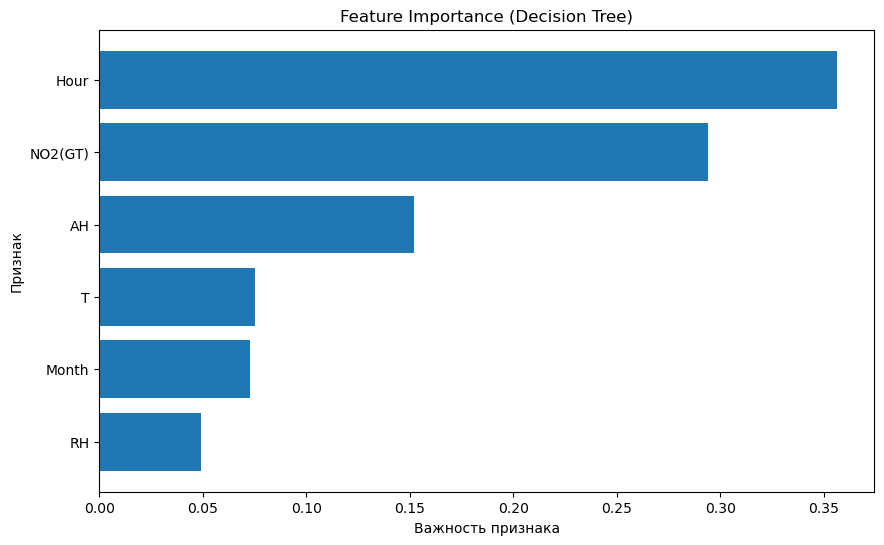

In [29]:
X_train = X_train.drop(columns=["PT08.S4(NO2)", "NOx(GT)"])
X_test = X_test.drop(columns=["PT08.S4(NO2)", "NOx(GT)"])

numerical_features = X_train.select_dtypes("number").columns
categorical_features = X_train.select_dtypes("object").columns

models = fit_models(numerical_features, categorical_features)

auc_df = train_test_auc_df(models, X_train, X_test)

# Я не знаю почему такой результат
display(auc_df)

plot_feature_importance(models["Decision Tree"], numerical_features, categorical_features)

## Результат пункта 4 (7-я попытка):

О переобученности и недообученности модели говорить пока нельзя. В результате моих удалений осталось всего 6 признаков и подумал что вожможно все дела в Target кодировании

---

In [30]:
numerical_features = X_train.select_dtypes("number").columns
categorical_features = X_train.select_dtypes("object").columns

X_train_nums = X_train[categorical_features].astype(int)
X_train_nums[numerical_features] = X_train[numerical_features]

X_test_nums = X_test[categorical_features].astype(int)
X_test_nums[numerical_features] = X_test[numerical_features]

X_train_nums.head()

,Month,Hour,NO2(GT),T,RH,AH
DateTime,,,,,,
2004-05-11 11:00,5,11,119.0,23.500,29.525000,0.843450
2005-01-13 17:00,1,17,159.8,12.350,63.000001,0.901485
2004-12-29 06:00,12,6,108.5,9.425,70.900000,0.838636
2004-05-27 07:00,5,7,108.5,16.975,46.024999,0.882995
2004-03-12 21:00,3,21,149.0,12.150,53.349999,0.753620


In [31]:
# Сделал все фичи числовыми и проверил без пайплайна
# чтобы проверить что ошибка не в ПАЙПАЛЙНЕ и не ТАРГЕТ кодировании

model = LogisticRegression()
model.fit(X_train_nums, y_train)

y_train_pred_proba = model.predict_proba(X_train_nums)[:, 1]
y_test_pred_proba = model.predict_proba(X_test_nums)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Train AUC: {train_auc.round(3)}")
print(f"Test AUC: {test_auc.round(3)}")

Train AUC: 0.876
Test AUC: 0.886


,Logistic Regression,KNN,Decision Tree
Train AUC,0.8760,0.9821,0.9789
Test AUC,0.8862,0.9180,0.8777


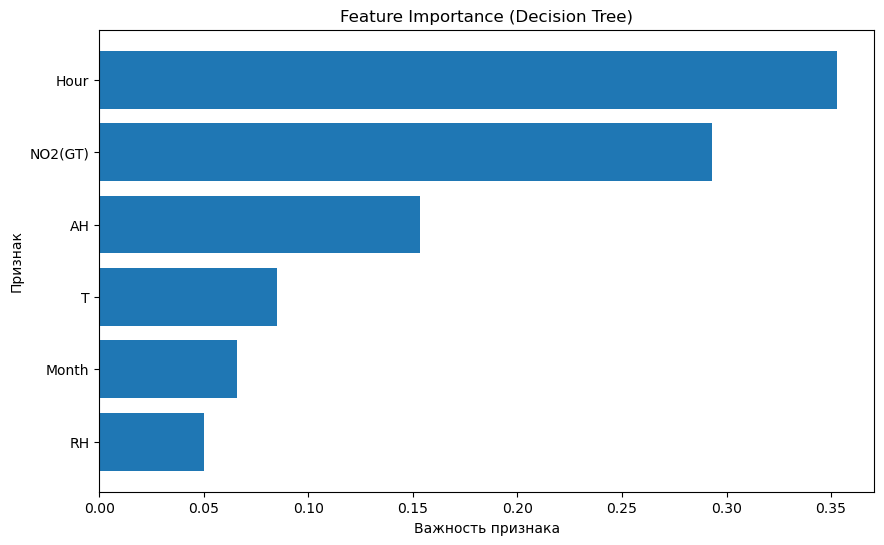

In [32]:
numerical_features = X_train_nums.select_dtypes("number").columns
categorical_features = X_train_nums.select_dtypes("object").columns

models = fit_models(numerical_features, categorical_features)

auc_df = train_test_auc_df(models, X_train_nums, X_test_nums)

# Я не знаю почему такой результат и остановлюсь на этом
display(auc_df)

plot_feature_importance(models["Decision Tree"], numerical_features, categorical_features)

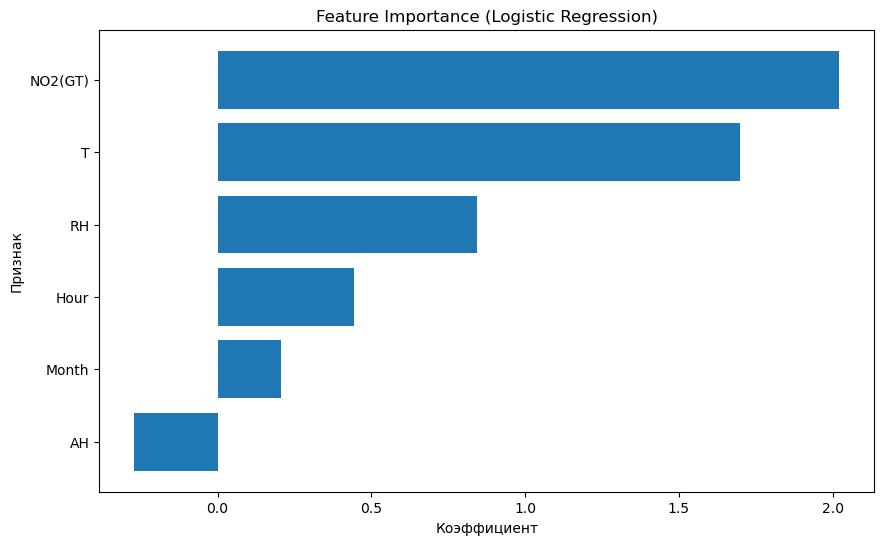

In [33]:
plot_logistic_regression_importance(models["Logistic Regression"], numerical_features, categorical_features)


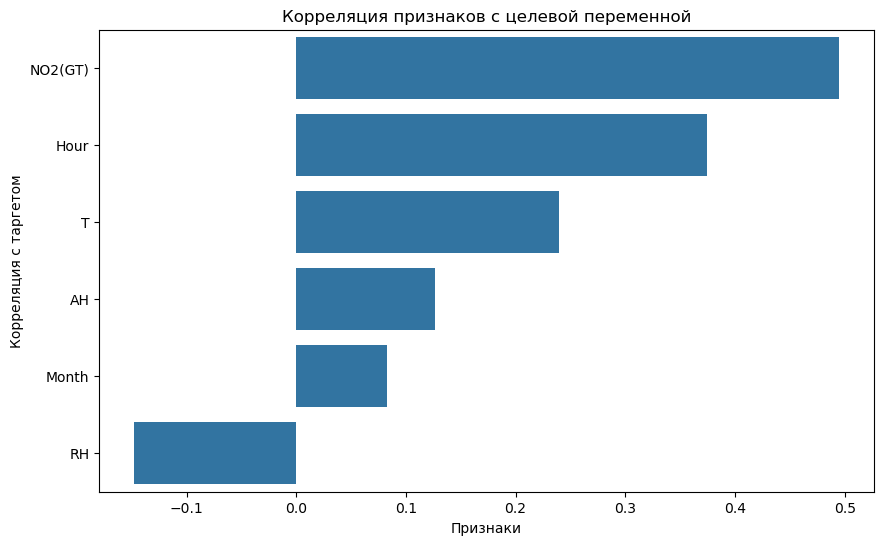

In [34]:
df_train = X_train.copy()
df_train["target"] = y_train

corr_target = df_train.corr()["target"][:-1].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_target, y=corr_target.index)
plt.xlabel("Признаки")
plt.ylabel("Корреляция с таргетом")
plt.title("Корреляция признаков с целевой переменной")
plt.show()

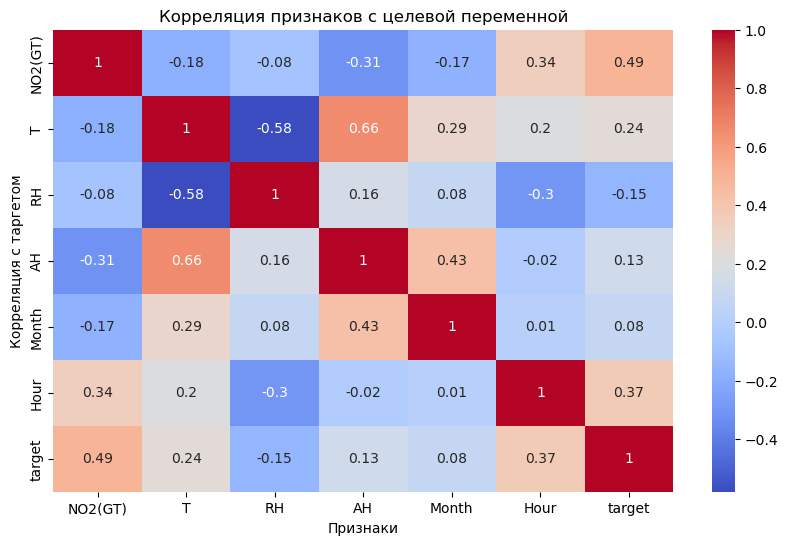

In [35]:
df_train = X_train.copy()
df_train["target"] = y_train

corr_mat = df_train.corr().round(2)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_mat, annot=True, cmap="coolwarm")
plt.xlabel("Признаки")
plt.ylabel("Корреляция с таргетом")
plt.title("Корреляция признаков с целевой переменной")
plt.show()

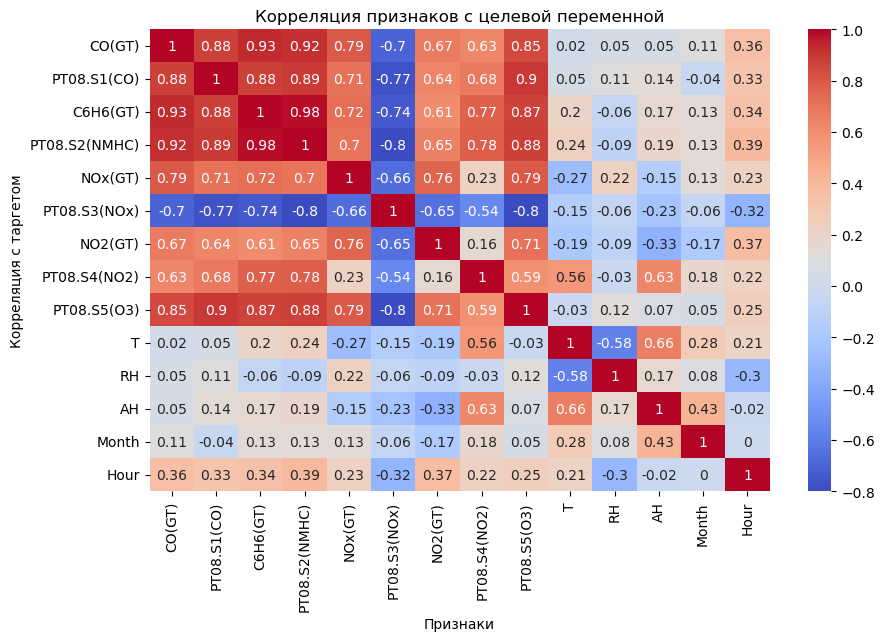

In [36]:
corr_mat = df.corr().round(2)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_mat, annot=True, cmap="coolwarm")
plt.xlabel("Признаки")
plt.ylabel("Корреляция с таргетом")
plt.title("Корреляция признаков с целевой переменной")
plt.show()

## Результат пункта 4 и 5 (8-я попытка - финальная):

Моделы KNN и Decision Tree явно переобучени и недообученности. В результате удалив 7 признаков **CO(GT), PT08.S1(CO), PT08.S2(NMHC), NOx(GT), PT08.S3(NOx), PT08.S4(NO2), PT08.S5(O3),** я добился результата который более или менее похож на правду. Я даже сделал все признаки числовыми и проверял результата без пайплайна и без Target кодировании, но получил такой же результат. Возможно утечка информации было в сильной связи концентрации газов в воздухе, судя по матрицы корреляции

Я проанализировал важность признаков для **Decision Tree** и **Logistic Regression** (но не для **KNN**, так как там ни как не считать важность признаков).  

- **Decision Tree** делает основной упор на **Hour** (время суток) и **NO2(GT)** (загрязнение воздуха), а остальные признаки менее значимы.  
- **Logistic Regression** сильнее зависит от **NO2(GT)** и **T** (температуры), но меньше учитывает время суток.  

В целом, дерево решений лучше улавливает нелинейные зависимости, а логистическая регрессия показывает, что уровень загрязнения и температура – ключевые факторы.

---

## 6. Оценка модели с использованием кросс-валидации 🔄
- Для лучшей модели проведите кросс-валидацию с использованием K-fold и Stratified K-fold.
- Выведите среднее значение и стандартное отклонение для каждой схемы кросс-валидации.


In [37]:
# Logistic Regression – наиболее сбалансированная модель,
# так как разница между Train и Test AUC минимальна,
# поэтому я выбрал его в качестве лучшей моделы,
# хотя конечно настроенный DT лучше будет работать.
auc_df

,Logistic Regression,KNN,Decision Tree
Train AUC,0.8760,0.9821,0.9789
Test AUC,0.8862,0.9180,0.8777


In [38]:
model = LogisticRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

kf_scores = cross_val_score(
    estimator=model,
    X=X_train,
    y=y_train,
    cv=kf,
    scoring='roc_auc'
)

skf_scores = cross_val_score(
    estimator=model,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='roc_auc'
)

kf_mean = kf_scores.mean()
skf_mean = skf_scores.mean()

kf_std = kf_scores.std()
skf_std = skf_scores.std()

result_df = pd.DataFrame({
    "Средный AUC": [kf_mean, skf_mean],
    "Стандартное отклонение": [kf_std, skf_std]
}, index=["K-Fold", "Stratify K-Fold"]).round(4)


result_df

,Средный AUC,Стандартное отклонение
K-Fold,0.8751,0.0088
Stratify K-Fold,0.8754,0.0098


## 7. Реализация Leave-One-Out Cross Validation 🧑‍🏫
- Напишите функцию, которая принимает датасет и проводит Leave-One-Out кросс-валидацию для метрики roc-auc.
- Обязательно используйте `typing` для аннотации типов данных в функции.
- Проведите LOOCV для 100 рандомных значений из датасета. Установите random_state = 42 при выборе 100 значений через метод sample.


In [39]:
def leave_one_out_cv(data: pd.DataFrame, target_column: str) -> Tuple[float, float]:
    """
    Выполняет Leave-One-Out Cross Validation (LOOCV) для модели Logistic Regression
    и оценивает её по метрике ROC-AUC.
    """
    loo = LeaveOneOut()
    model = LogisticRegression()

    X = data.drop(columns=[target_column])
    y = data[target_column]

    auc_scores = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if len(np.unique(y_test)) < 2:
            continue

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]

        auc_scores.append(roc_auc_score([y_test], y_pred))

    if len(auc_scores) == 0:
        print("Ошибка: Все фолды содержали только один класс")
        return np.nan, np.nan

    return np.mean(auc_scores), np.std(auc_scores)


In [40]:
def leave_two_stratified_cv(data: pd.DataFrame, target_column: str) -> Tuple[float, float]:
    """
    Выполняет кросс-валидацию Leave-2-Out, где один объект тестовой выборки из класса 0,
    а второй объект тестовой выборки из класса 1.
    """
    model = LogisticRegression()

    # Разделяем признаки и целевую переменную
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Разделяем индексы по классам
    class_0_indices = y[y == 0].index
    class_1_indices = y[y == 1].index

    auc_scores = []

    # Перебираем все возможные пары (один из 0, один из 1)
    for idx_0, idx_1 in zip(class_0_indices, class_1_indices):
        test_index = [idx_0, idx_1]  # Два объекта в тесте
        train_index = list(set(y.index) - set(test_index))  # Остальные в train

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]

        auc_scores.append(roc_auc_score(y_test, y_pred))

    # Вычисляем средний AUC и стандартное отклонение
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    return mean_auc, std_auc

In [41]:
print(f"Распределение классов в y_train:\n{y_train.value_counts()}")

# Выбираю 100 случайных строк, балансируя классы
balanced_indices = y_train.groupby(y_train).apply(lambda x: x.sample(100, random_state=42)).index.get_level_values(1)
print(f"\nВывод y_train после балансировки классов: \n{y_train[balanced_indices].value_counts()}")

random_sample = X_train.loc[balanced_indices].copy()
random_sample["target"] = y_train.loc[balanced_indices]

# Выполняю Leave-1-Out Cross Validation
mean_auc_1, std_auc_1 = leave_one_out_cv(random_sample, "target")

# Выполняю Leave-2-Out Cross Validation
mean_auc_2, std_auc_2 = leave_two_stratified_cv(random_sample, "target")

# Создаю DataFrame с результатами обоих методов
loo_results = pd.DataFrame({
    "Метрика": ["Leave-1-Out ROC-AUC", "Leave-2-Out ROC-AUC"],
    "Среднее значение": [mean_auc_1, mean_auc_2],
    "Стандартное отклонение": [std_auc_1, std_auc_2]
}).round(3)

loo_results

Распределение классов в y_train:
C6H6(GT)
0    3397
1    3346
Name: count, dtype: int64

Вывод y_train после балансировки классов: 
C6H6(GT)
0    100
1    100
Name: count, dtype: int64
Ошибка: Все фолды содержали только один класс


,Метрика,Среднее значение,Стандартное отклонение
0,Leave-1-Out ROC-AUC,NaN,NaN
1,Leave-2-Out ROC-AUC,0.86,0.347


## 8. Задание с самостоятельным изучением: Подбор параметров моделей с использованием GridSearch 🔍
- Проведите подбор гиперпараметров для моделей KNN и Logistic Regression с использованием библиотеки `GridSearch`.

In [42]:
def hyperparameter_tuning(models: Dict[str, object], X_train: pd.DataFrame, y_train: pd.Series) -> pd.DataFrame:
    """
    Проводит подбор гиперпараметров для моделей KNN, Logistic Regression и Decision Tree с помощью GridSearchCV.

    """

    # Определяем гиперпараметры для KNN
    knn_params = {
        "classifier__n_neighbors": [3, 5, 7, 9, 11],
        "classifier__weights": ["uniform", "distance"],
        "classifier__metric": ["euclidean", "manhattan"]
    }

    # Определяем гиперпараметры для Logistic Regression
    logreg_params = {
        "classifier__C": [0.01, 0.1, 1, 10, 100],
        "classifier__penalty": ["l1", "l2"],
        "classifier__solver": ["liblinear", "saga"]
    }

    # Определяем гиперпараметры для Decision Tree
    dt_params = {
        "classifier__max_depth": [5, 10, 15, 20, None],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 5],
        "classifier__criterion": ["gini", "entropy"]
    }

    # Функция для выполнения GridSearchCV
    def grid_search_model(model_pipeline, param_grid):
        grid_search = GridSearchCV(model_pipeline, param_grid, scoring="roc_auc", cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

    # Оптимизация KNN
    best_knn_model, best_knn_params, best_knn_score = grid_search_model(models["KNN"], knn_params)

    # Оптимизация Logistic Regression
    best_logreg_model, best_logreg_params, best_logreg_score = grid_search_model(models["Logistic Regression"], logreg_params)

    # Оптимизация Decision Tree
    best_dt_model, best_dt_params, best_dt_score = grid_search_model(models["Decision Tree"], dt_params)

    # Формируем таблицу с лучшими параметрами
    best_params_df = pd.DataFrame({
        "Модель": ["KNN", "Logistic Regression", "Decision Tree"],
        "Лучшие параметры": [best_knn_params, best_logreg_params, best_dt_params],
        "Лучший AUC": [best_knn_score, best_logreg_score, best_dt_score]
    })

    return best_params_df



In [43]:
best_params_df = hyperparameter_tuning(models, X_train, y_train)


In [44]:
best_params_df

,Модель,Лучшие параметры,Лучший AUC
0,KNN,"{'classifier__metric': 'manhattan', 'classifie...",0.938236
1,Logistic Regression,"{'classifier__C': 100, 'classifier__penalty': ...",0.875734
2,Decision Tree,"{'classifier__criterion': 'entropy', 'classifi...",0.903842


In [45]:
best_models_params = best_params_df["Лучшие параметры"].to_dict()
best_models_params

{0: {'classifier__metric': 'manhattan',
  'classifier__n_neighbors': 11,
  'classifier__weights': 'distance'},
 1: {'classifier__C': 100,
  'classifier__penalty': 'l1',
  'classifier__solver': 'liblinear'},
 2: {'classifier__criterion': 'entropy',
  'classifier__max_depth': 10,
  'classifier__min_samples_leaf': 5,
  'classifier__min_samples_split': 10}}